In [1]:
import measures, umls_tables_processing, utils
import datetime
from collections import defaultdict

from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
# import data_visualization

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd


0:06:05


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2v_48f5q because the default path (/home/salvatore/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Processing MRREL table: elaboration of relationships and evaluation of which is more proper

In [37]:
_ = umls_tables_processing.count_relationships(rel_type = 'RELA')

844
0:01:06


This is the number of all the relationships `RELA` in the whole UMLS: they correspond to the particular relationships

In [3]:
umls_tables_processing.count_relationships(rel_type = 'REL')

10
0:02:41


{'AQ', 'CHD', 'PAR', 'QB', 'RB', 'RN', 'RO', 'RQ', 'SIB', 'SY'}

These are the `REL` relationships and the total number: they correspond to generical relationships

The following lines tell us which are the relationship which link the 256 elements of the seed with the concept `COPD`: this is an evolution of the original seed building method.

In [4]:
double_rel = umls_tables_processing.concepts_related_to_concept(two_way = True, polishing_rels = True, switch_key= 'con')

Relation '' discarded 


In [5]:
single_rel = umls_tables_processing.concepts_related_to_concept(two_way = False, polishing_rels = True, switch_key= 'con')

Relation '' discarded 


The two lines distinguish the both ways relationships from the one way.

#### Double ways

In [6]:
_ = set([i for j in double_rel.values() for i in j])
print(_)
print(len(_))

{'disease_has_associated_gene', 'may_be_treated_by', 'disease_has_associated_anatomic_site', 'focus_of', 'is_associated_anatomic_site_of', 'fragments_for_synonyms_of', 'contraindicated_with_disease', 'has_fragments_for_synonyms', 'was_a', 'classified_as', 'same_as', 'has_finding_site', 'possibly_equivalent_to', 'inverse_was_a', 'inverse_isa', 'finding_site_of', 'has_associated_morphology', 'entry_version_of', 'see_from', 'has_course', 'has_cdrh_parent', 'has_focus', 'replaces', 'has_expanded_form', 'expanded_form_of', 'cdrh_parent_of', 'has_entry_version', 'associated_with_malfunction_of_gene_product', 'associated_morphology_of', 'subset_includes_concept', 'clinical_course_of', 'use', 'related_to', 'isa', 'used_for', 'gene_associated_with_disease', 'has_answer', 'has_contraindicated_drug', 'answer_to', 'has_associated_finding', 'replaced_by', 'has_clinical_course', 'mapped_from', 'concept_in_subset', 'may_treat', 'classifies', 'gene_product_malfunction_associated_with_disease', 'see', 

#### One way

In [7]:
_ = set([i for j in single_rel.values() for i in j])
print(_)
print(len(_))

{'is_associated_anatomic_site_of', 'contraindicated_with_disease', 'has_fragments_for_synonyms', 'was_a', 'classified_as', 'same_as', 'possibly_equivalent_to', 'inverse_was_a', 'inverse_isa', 'finding_site_of', 'has_focus', 'entry_version_of', 'see_from', 'has_cdrh_parent', 'has_expanded_form', 'expanded_form_of', 'cdrh_parent_of', 'has_entry_version', 'associated_morphology_of', 'subset_includes_concept', 'clinical_course_of', 'use', 'related_to', 'isa', 'used_for', 'gene_associated_with_disease', 'has_answer', 'has_associated_finding', 'replaced_by', 'mapped_from', 'may_treat', 'gene_product_malfunction_associated_with_disease', 'see', 'mapped_to', 'has_manifestation', 'course_of'}
36


#### Building the seed for analogic evaluation: we obtain lists of CUIs for each relationship in which they're involved with COPD

In [4]:
seed_analog_both = umls_tables_processing.concepts_related_to_concept(two_way = True, switch_key = 'rel', extract_labels = True)
print(len(seed_analog_both))
#seed_analog_both

0:02:15
256
Time for extracting labels: 0:00:00
Extracting time: 0:02:15
Building seed time: 0:03:37
54


In [4]:
seed_analog_one = umls_tables_processing.concepts_related_to_concept(two_way = False, switch_key = 'rel')
print(len(seed_analog_one))
#seed_analog_one

0:00:52
37


In place of building the list of copd-related CUIs, the seed_analog_one is re-elaborated for returning a list of concepts.

The seed_analog_one is used just for the reason it has not extracted labels, so it is more comfortable handling it.

In [6]:
tmp = [v for k,v in seed_analog_one.items()]
concepts = list(set([i for j in tmp for i in j]))

In counting the number of RELA relationships, the second approach return one more relation: it is due to the presence of the emtpy relation `''`

The `''` relation is problematic because contains plenty of key-concepts for our case and it is more similar to the concept of `relatedness`

The two sets of L and K are built: the boundary for the first is just the presence of relationships COPD-related.

In [7]:
all_copd_relations = list(seed_analog_both.keys())

### A subset of the 53 relationships extracted from seed, is detected

#### Used relationships (RELA)

They are choosen by hand

In [5]:
useful_rela = umls_tables_processing.USEFUL_RELA
useful_rela.append('')
useful_rela

['associated_finding_of',
 'associated_morphology_of',
 'associated_with_malfunction_of_gene_product',
 'clinical_course_of',
 'contraindicated_with_disease',
 'course_of',
 'disease_has_associated_anatomic_site',
 'disease_has_associated_gene',
 'finding_site_of',
 'gene_associated_with_disease',
 'gene_product_malfunction_associated_with_disease',
 'has_associated_finding',
 'has_associated_morphology',
 'has_clinical_course',
 'has_contraindicated_drug',
 'has_course',
 'has_finding_site',
 'has_manifestation',
 'is_associated_anatomic_site_of',
 'manifestation_of',
 'may_be_treated_by',
 'may_treat',
 '']

Building of K sets: two sets are built, one with both elements related to COPD and the other one to all the pairs which at least an element belonging to seed (the 256 elements extracted to one hop far by COPD concept)  

In [ ]:
concepts = umls_tables_processing.concepts_related_to_concept(concept = umls_tables_processing.COPD,
                                                              two_way = True,
                                                              polishing_rels = False,
                                                              switch_key = 'con',
                                                              extract_labels = False)

K_umls_copd = umls_tables_processing.count_pairs(umls_tables_processing.USEFUL_RELA, 
                                                 cuis_list = [umls_tables_processing.COPD])


In [2]:
K_umls_copd = utils.inputs_load('Utilities/K_umls_copd')

0:00:00


In [ ]:
K_umls = umls_tables_processing.count_pairs(useful_rela, cuis_list = concepts)

In [3]:
K_umls = utils.inputs_load('Utilities/K_umls')

0:00:03


In [ ]:
L_umls = umls_tables_processing.count_pairs(umls_tables_processing.USEFUL_RELA)

In [4]:
L_umls = utils.inputs_load('Utilities/L_umls')

0:00:37


### Building a dictionary with all the CUIs of L_umls and the correspondent labels.

- 1 step: a set of unique CUIs taken from the pairs of L_umls is built. 
-  2 step: for each, all the correspondent labels are extracted.
##### A dictionary built in this way could be used in `analogy_compute` and it is even useful for building the K set

####  A good way to operate could be filtering the `dict_labels_for_L` with the Vocabular of embedding: performing an intersection

This process is the step before running the analogy pipeline for w2v embeddings.

In [ ]:
# Building the dictionary for labels case
# Collecting all the CUIs involved in set L
jh = []
for v in L_umls.values():
    jh.append(list(set(list(zip(*v))[0])))
    jh.append(list(set(list(zip(*v))[1])))
    tmp = set([j for i in jh for j in i ])
dict_strings = umls_tables_processing.cui_strings()    
dict_labels_for_L, _ = umls_tables_processing.extracting_strings(list(tmp), dict_strings = dict_strings)

In [4]:
dict_labels_for_L = utils.inputs_load('Utilities/dict_labels_for_L')

0:00:17


### Loading all the embeddings paths for evaluating the cardinality of filtered IoV pairs.

Loading models and used variables

In [5]:
PATH_EMBEDDINGS = './Embeddings'
sets_relations = defaultdict(list)

cuis = ('/cuis/', [f.name for f in scandir(PATH_EMBEDDINGS+'/cuis') if (f.is_file())&(f.name != 'README.md')])
words = ('/words/', [f.name for f in scandir(PATH_EMBEDDINGS+'/words') if (f.is_file())&(f.name != 'README.md')])
embeddings = [cuis, words]
embeddings

[('/cuis/',
  ['claims_cuis_hs_300.txt.gz',
   'stanford_cuis_svd_300.txt.gz',
   'cui2vec_pretrained.txt',
   'DeVine_etal_200.txt']),
 ('/words/',
  ['PMC-w2v.bin',
   'Health_2.5mreviews.s200.w10.n5.v15.cbow.bin',
   'PubMed-and-PMC-w2v.bin',
   'GoogleNews-vectors-negative300.bin',
   'PubMed-w2v.bin',
   'tweetsvec.txt',
   'wikipedia-pubmed-and-PMC-w2v.bin'])]

### Cardinality of filtered sets per relation:

The code is taken from `analogy_pipeline` script

In [ ]:
a = datetime.datetime.now().replace(microsecond=0)

# Loop over the relations
for type_emb in embeddings:
    for emb in type_emb[1]:
        model = KeyedVectors.load_word2vec_format(PATH_EMBEDDINGS+type_emb[0]+emb, binary=emb.endswith('.bin'))
        name = os.path.splitext(emb)[0]
        print('Embedding ' + str(name) + ' is analyzed')
        for rela in useful_rela:
            # Check type of embedding
            if type_emb[0]=='/cuis/':
                c = datetime.datetime.now().replace(microsecond=0)
                l0, k0 = measures.k_n_l_iov(L_umls[rela], 
                                            K_umls[rela],
                                            model, 
                                            emb_type = 'cui')

                # sets_relations keeps track of the number of pairs of K and L sets. 
                # The number of filtered pairs on Vemb, per relation are stored
                sets_relations[rela].append(('L_'+name, np.shape(l0)))
                sets_relations[rela].append(('K_'+name, np.shape(k0)))
                #print(rela + ' for ' + name + ' finished!')
                    
            # Check type of embedding: for word embeddings the dictionary of labels per cui is required
            elif (type_emb[0]=='/words/') and (dict_labels_for_L is not None):
                c = datetime.datetime.now().replace(microsecond=0)
            
                # Filter the dictionary of labels keeping only the labels-words present into the embedding
                Vemb = utils.extract_w2v_vocab(model)
                dict_labels_inters_vemb = umls_tables_processing.discarding_labels_oov(Vemb, dict_labels_for_L)
            
                # Filtering L and K sets for present labels inside the embedding
                l0, k0 = measures.k_n_l_iov(L_umls[rela], 
                                            K_umls[rela],
                                            model, 
                                            dict_labels_for_L = dict_labels_inters_vemb,
                                            emb_type = 'labels')
        
                # Store number of filtered pairs
                sets_relations[rela].append(('L_'+name, np.shape(l0)))
                sets_relations[rela].append(('K_'+name, np.shape(k0)))

utils.inputs_save(sets_relations, 'Utilities/rela_dict_wor')                
print('Execution time : ' + str(datetime.datetime.now().replace(microsecond=0) - a) + '\n')

In [12]:
for rela in useful_rela:
    sets_relations[rela].append(('L', np.shape(L_umls[rela])))
    sets_relations[rela].append(('K', np.shape(K_umls[rela])))
utils.inputs_save(sets_relations, 'Utilities/rela_dict_wor')

In [63]:
sets_relations_r = utils.inputs_load('Utilities/rela_dict')

0:00:00


In [64]:
sets_relations_r

defaultdict(list,
            {'associated_finding_of': [('L_claims_cuis_hs_300.txt', (97, 2)),
              ('K_claims_cuis_hs_300.txt', (15, 2)),
              ('L_stanford_cuis_svd_300.txt', (0,)),
              ('K_stanford_cuis_svd_300.txt', (0,)),
              ('L_cui2vec_pretrained', (1388, 2)),
              ('K_cui2vec_pretrained', (118, 2)),
              ('L_DeVine_etal_200', (684, 2)),
              ('K_DeVine_etal_200', (43, 2)),
              ('L_PMC-w2v', (290, 2)),
              ('K_PMC-w2v', (18, 2)),
              ('L_Health_2.5mreviews.s200.w10.n5.v15.cbow', (167, 2)),
              ('K_Health_2.5mreviews.s200.w10.n5.v15.cbow', (5, 2)),
              ('L_PubMed-and-PMC-w2v', (298, 2)),
              ('K_PubMed-and-PMC-w2v', (18, 2)),
              ('L_GoogleNews-vectors-negative300', (244, 2)),
              ('K_GoogleNews-vectors-negative300', (17, 2)),
              ('L_PubMed-w2v', (296, 2)),
              ('K_PubMed-w2v', (18, 2)),
              ('L_tweetsvec',

In [13]:
sets_relations

defaultdict(list,
            {'associated_finding_of': [('L_claims_cuis_hs_300.txt', (57, 2)),
              ('K_claims_cuis_hs_300.txt', (10, 2)),
              ('L_stanford_cuis_svd_300.txt', (0,)),
              ('K_stanford_cuis_svd_300.txt', (0,)),
              ('L_cui2vec_pretrained', (827, 2)),
              ('K_cui2vec_pretrained', (58, 2)),
              ('L_DeVine_etal_200', (446, 2)),
              ('K_DeVine_etal_200', (23, 2)),
              ('L_PMC-w2v', (183, 2)),
              ('K_PMC-w2v', (9, 2)),
              ('L_Health_2.5mreviews.s200.w10.n5.v15.cbow', (109, 2)),
              ('K_Health_2.5mreviews.s200.w10.n5.v15.cbow', (4, 2)),
              ('L_PubMed-and-PMC-w2v', (188, 2)),
              ('K_PubMed-and-PMC-w2v', (9, 2)),
              ('L_GoogleNews-vectors-negative300', (151, 2)),
              ('K_GoogleNews-vectors-negative300', (8, 2)),
              ('L_PubMed-w2v', (187, 2)),
              ('K_PubMed-w2v', (9, 2)),
              ('L_tweetsvec', (77, 

#### K and L cardinality data preparation

In [14]:
sets_rels_ordered = {}
for key, values in sets_relations.items():
    sets_rels_ordered[key] = ([val[1][0] for i, val in enumerate(values) if (i%2==0)], [val[1][0] for i, val in enumerate(values) if (i%2!=0)])    

# Plot with repetead couples

### Plot K_sets cardinality

Text(0, 0.5, 'Cardinality')

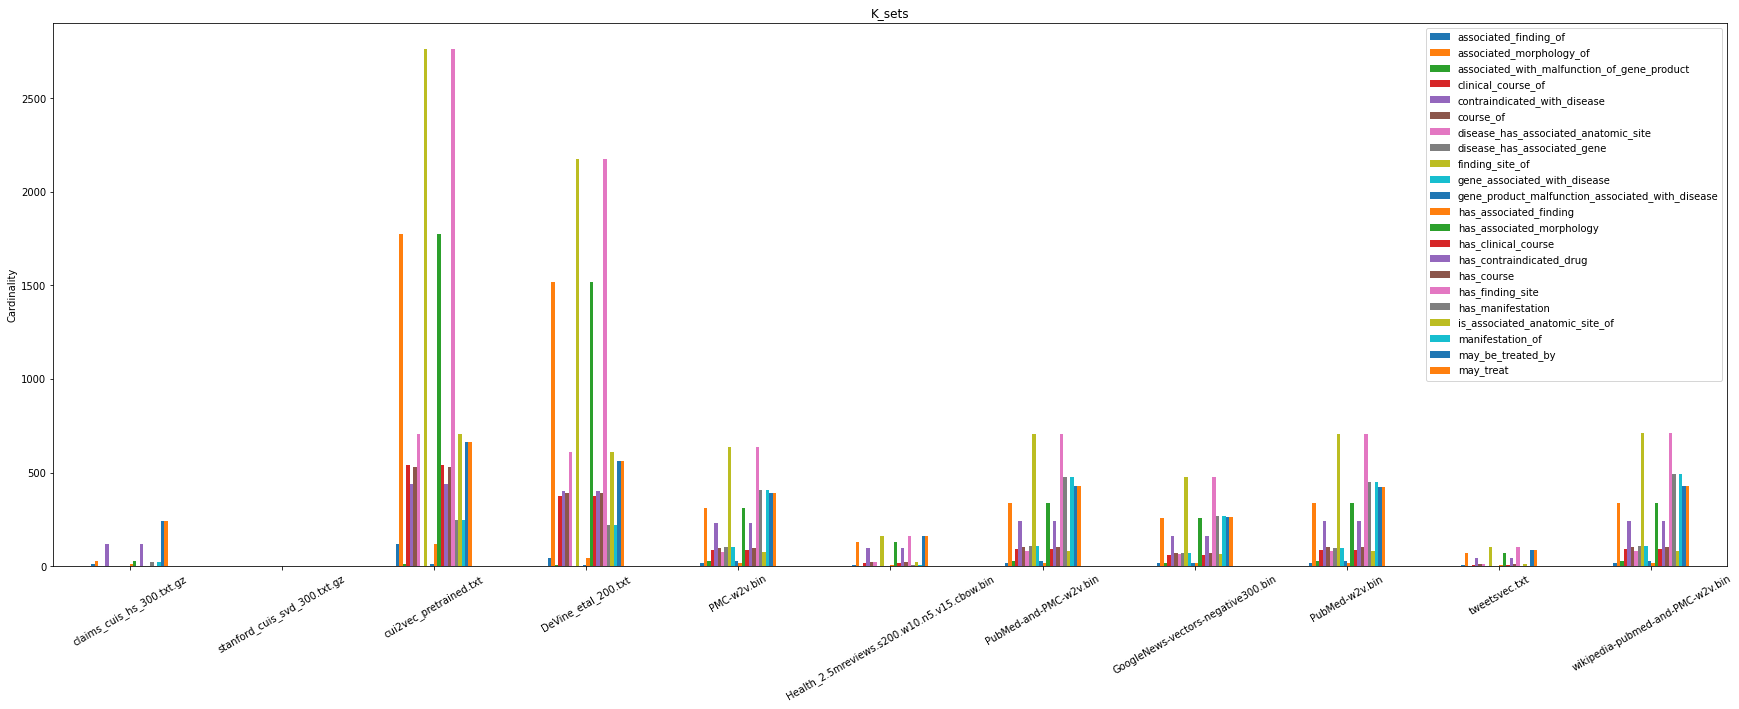

In [151]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[1][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("K_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Plot L-sets cardinality

Text(0, 0.5, 'Cardinality')

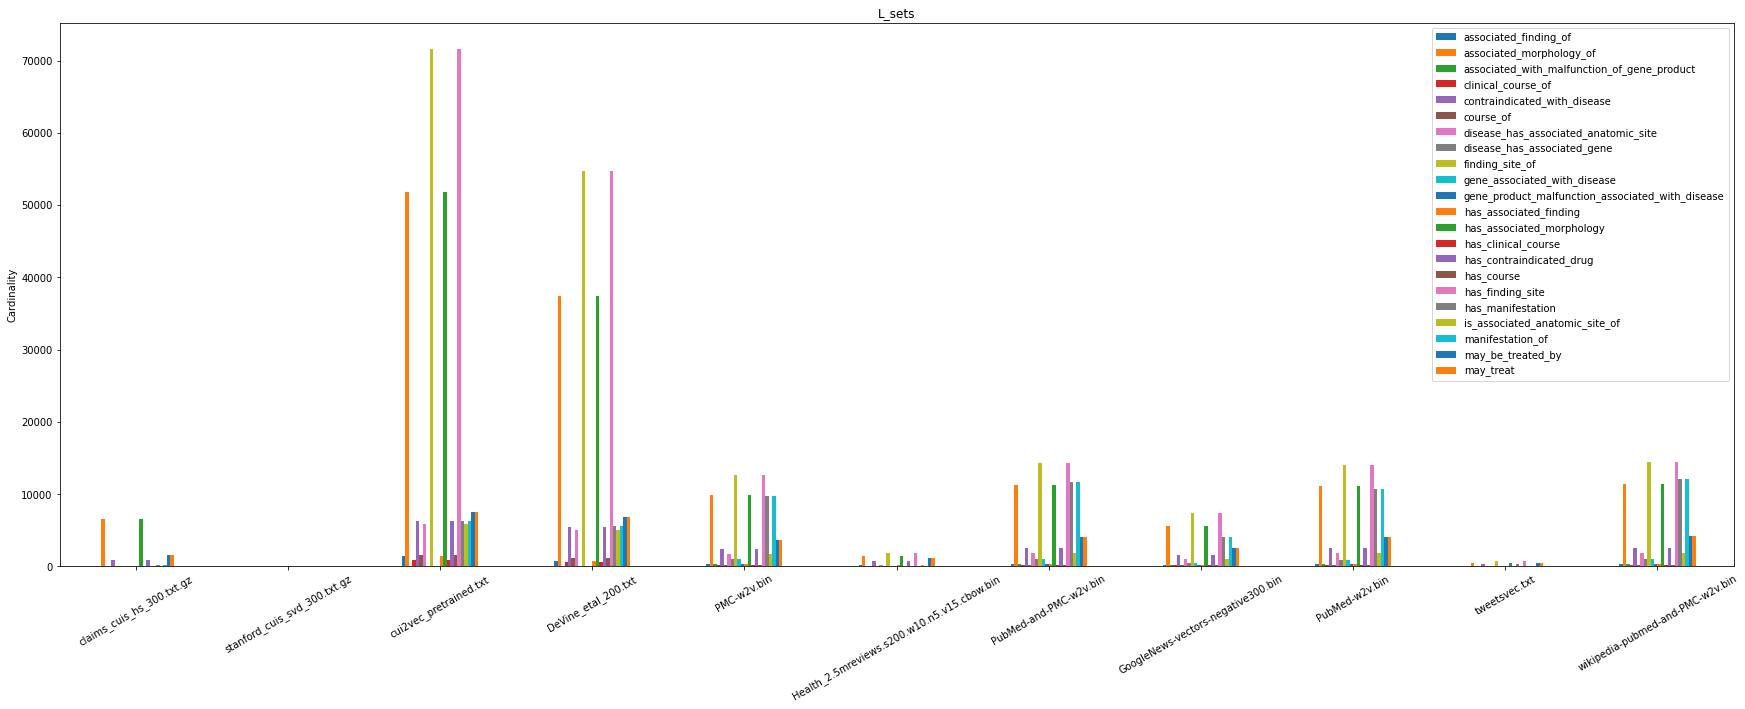

In [152]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[0][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("L_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

# Plot without repeated couples

### Plot K_sets cardinality

Text(0, 0.5, 'Cardinality')

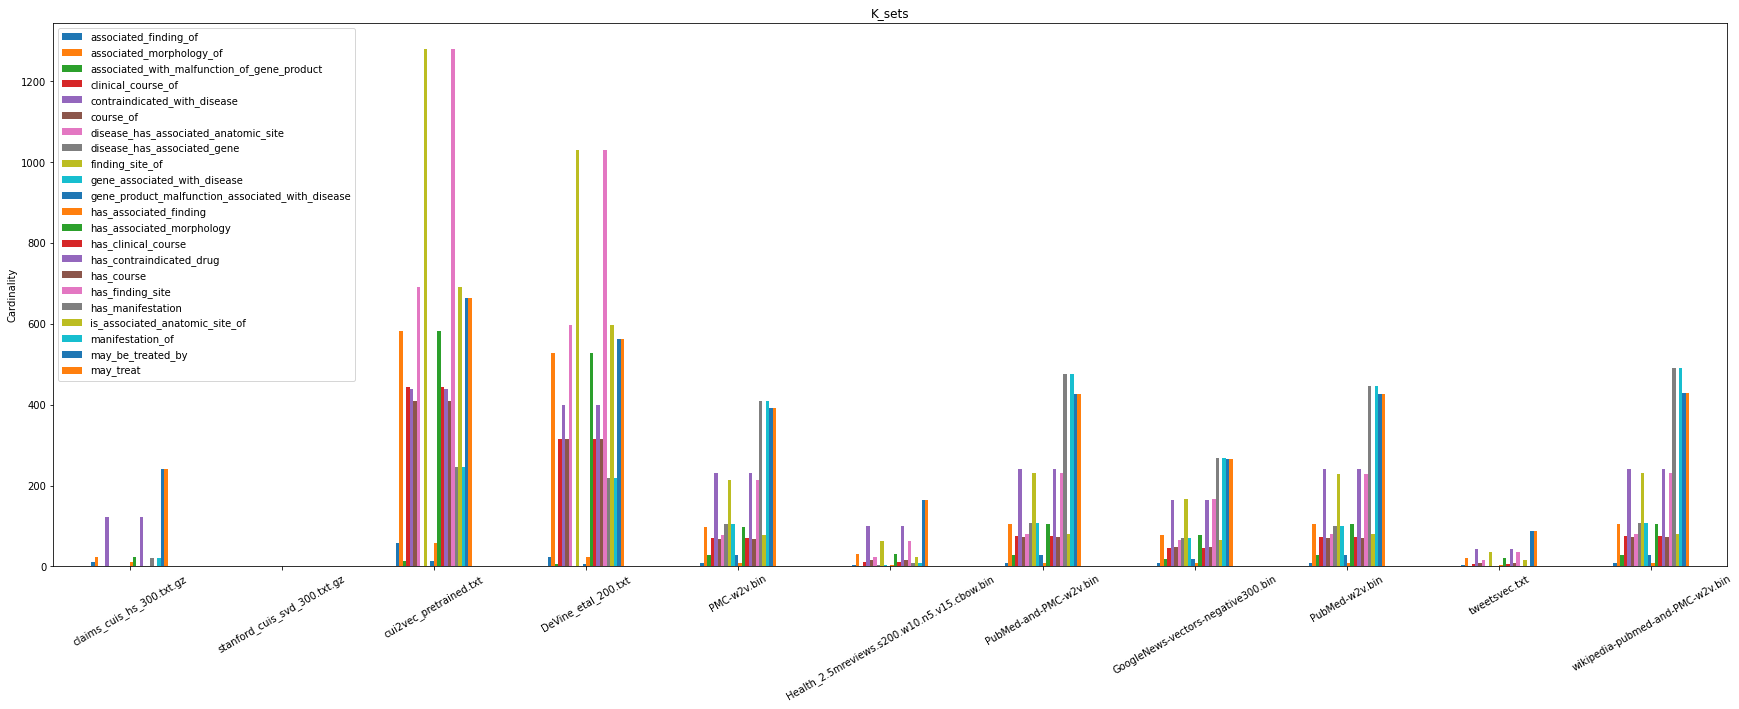

In [18]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

plt.rcParams["figure.figsize"] = (30,10)

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[1][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("K_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Plot L-sets cardinality

Text(0, 0.5, 'Cardinality')

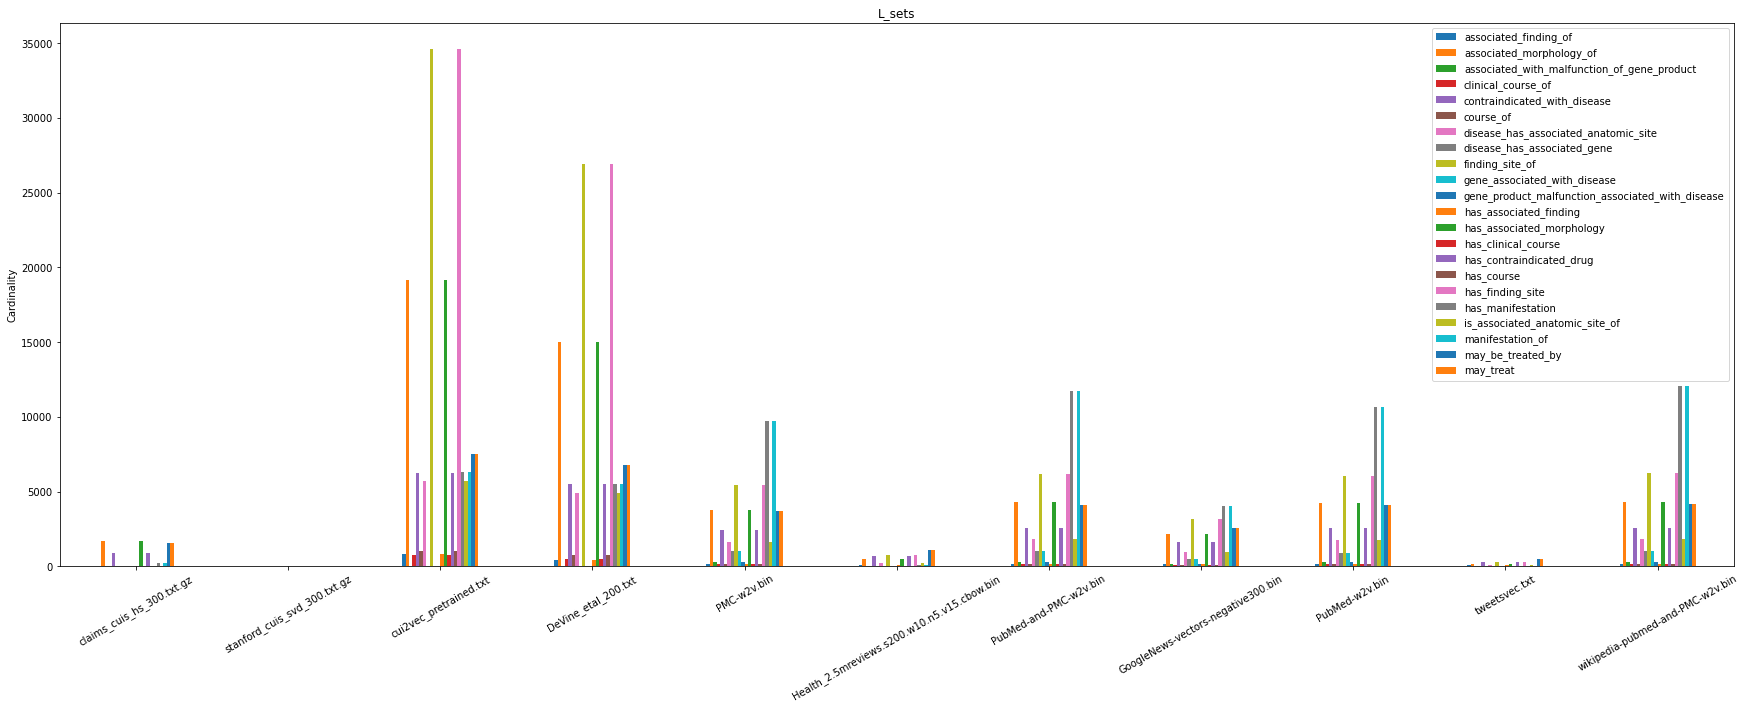

In [19]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[0][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("L_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Extracting labels by K_umls_copd pairs, for understanding the semantics of each relations 

In [3]:
#dict_strings = umls_tables_processing.cui_strings()
dict_strings = utils.inputs_load('Utilities/dict_conso')

0:00:15


This print showed how the concepts are related each others in UMLS: they have reverse direction. 

The first element of couple is semantically the second one, which is bounded thanks to a relation to the second element of couple, which is semantically the first one.

The methods in `umls_tables_processing` already compute the reversing operation

In [10]:
for k,v in K_umls_copd.items():
    print(v[0])
    first = list(zip(*v))[0][0] 
    first, _ = umls_tables_processing.extracting_strings([first], dict_strings = dict_strings)
    second = list(zip(*v))[1][0]
    second, _ = umls_tables_processing.extracting_strings([second], dict_strings = dict_strings)
    print(str(list(first.values())[0][0])+ ' ' + k + ' ' + str(list(second.values())[0][0]) + '\n')

('C0024117', 'C0001792')
0:00:00
0:00:00
Chronic Obstructive Airway Disease  Elderly (population group)

('C0024117', 'C0001883')
0:00:00
0:00:00
Chronic Obstructive Airway Disease isa Airway Obstruction

('C0024117', 'C0004096')
0:00:00
0:00:00
Chronic Obstructive Airway Disease related_to ARNASESTUA

('C0024117', 'C0006267')
0:00:00
0:00:00
Chronic Obstructive Airway Disease inverse_isa Bronchiectasis

('C0024117', 'C0006270')
0:00:00
0:00:00
Chronic Obstructive Airway Disease has_finding_site Bronchioles

('C0024117', 'C0024109')
0:00:00
0:00:00
Chronic Obstructive Airway Disease disease_has_associated_anatomic_site Lung

('C0024117', 'C0024117')
0:00:00
0:00:00
Chronic Obstructive Airway Disease see_from Chronic Obstructive Airway Disease

('C0024117', 'C0024117')
0:00:00
0:00:00
Chronic Obstructive Airway Disease entry_version_of Chronic Obstructive Airway Disease

('C0040233', 'C0024117')
0:00:00
0:00:00
timolol contraindicated_with_disease Chronic Obstructive Airway Disease

('C

### A toy example is coded below for our analogy computation:

A CUI embedding is loaded

In [6]:
dv = 'Embeddings/cuis/DeVine_etal_200.txt'

a = datetime.datetime.now().replace(microsecond=0)
model = KeyedVectors.load_word2vec_format(dv, binary=False)
print(datetime.datetime.now().replace(microsecond=0)-a)

0:00:22


In [18]:
rela = 'may_treat'

A random `RELA` is choosen

In [19]:
len(K_umls[rela])

1208

In [20]:
l0, k0 = measures.k_n_l_iov(K_umls[rela], K_umls[rela], model, emb_type = 'cui')

(2, 1208)
L=k
0:00:00
563


With `l0=k0` 

In [19]:
len(l0)==len(k0)

True

In [20]:
print(len(l0))

563


In [21]:
len(l0)*len(l0)

316969

Code lines taken from `analogy_compute` in `measures`

In [22]:
a = datetime.datetime.now().replace(microsecond=0)
storing_list_add = []
storing_list_mul = []
storing_list_dir = []
k_most_similar = 10
eps = 0.0001

for concept_L in l0:
    for concept_K in k0:
        # This check returns a number of analogy computed fewer than the number of starting pairs (K and L)
        if concept_L != concept_K:
            #if len(check)==0:
            storing_list_add = measures.cos3add(concept_L, concept_K, model, k_most_similar, storing_list_add)
            storing_list_mul = measures.cos3mul(concept_L, concept_K, model, storing_list_mul, epsilon = eps)
            storing_list_dir = measures.pair_direction(concept_L, concept_K, model, storing_list_dir, epsilon = eps)

print(datetime.datetime.now().replace(microsecond=0)-a)

0:50:08


Magnitude of 3CosAdd, normalized for the number of computations: it does not correspond to the exact product

The same pairs are discarded

In [23]:
print('The occurrences using 3CosAdd (analogic reasoning), for rela ' +rela+ '  is: '+str(sum(list(zip(*storing_list_add))[2])/len(storing_list_add)))

The occurrences using 3CosAdd (analogic reasoning), for rela may_treat  is: 0.033216816368842564


In [24]:
print('The occurrences using 3CosMul, for rela ' +rela+ '  is: '+str(sum(list(zip(*storing_list_mul))[2])/len(storing_list_mul)))

The occurrences using 3CosMul, for rela may_treat  is: 0.5713659039716059


In [25]:
print('The value of pair_direction, for rela ' +rela+ ' is: '+str(sum(list(zip(*storing_list_dir))[2])/len(storing_list_dir)))

The value of pair_direction, for rela may_treat is: 0.21822307969204216


Try to check in place of `1-distance.cosine` the `model.similarity`, just for coherence: checked

`model.similarity`, the `gensim` method for computing the cosine similarity among words, does not work in this case, because it does not work on vectors, but only on IoV strings. 

The following code is taken by https://github.com/rishibommasani/Contextual2Static in particular way, it is interesting the aspect related to the bias computation, thanks to the usage of PCA first component.

In [7]:
from sklearn.decomposition import PCA
from scipy import spatial

def compute_bias_direction(embeddings, seed_pairs):
    a = datetime.datetime.now().replace(microsecond=0)
    diff_embeddings = [embeddings[x] - embeddings[y] for x,y in seed_pairs]
    X = np.array(diff_embeddings)
    pca = PCA(n_components=1)
    pca.fit(X)
    print(datetime.datetime.now().replace(microsecond=0)-a)
    return pca.components_[0], pca.explained_variance_ratio_[0]


def compute_bias_on_emb(model, g):
    vemb = utils.extract_w2v_vocab(model)
    print(len(vemb))
    return sum([(1 - spatial.distance.cosine(model[w],g)) for w in vemb]) / len(vemb)

In [50]:
print(len(K_umls['may_treat']))

l0, k0 = measures.k_n_l_iov(K_umls['may_treat'], K_umls['may_treat'], model, emb_type = 'cui')
print(len(l0))

a, b = compute_bias_direction(model, l0)

print(len(a))

1208
(2, 1208)
0:00:00
563
0:00:01
200


Check the time requested for computing the direction for one of the biggest list of pairs:

In [54]:
l0, k0 = measures.k_n_l_iov(L_umls['finding_site_of'], K_umls['finding_site_of'], model, emb_type = 'cui')
direct, _ = compute_bias_direction(model, l0)

(2, 371662)
0:04:38
0:00:05


The computation is cheap in terms of time. Just 5 seconds for a list of couple of cardinality:

In [55]:
print(len(l0))

54727


The 4 minutes time is related to the couple IoV filtering time

In [59]:
compute_bias_on_emb(model, direct)

0.2763405913983587

In [82]:
def compute_bias_on_K(K, model, g):
    first = set(list(zip(*K))[0])
    second = set(list(zip(*K))[1])
    first.update(second)
    print(len(first))
    return sum([(1 - spatial.distance.cosine(model[w],g)) for w in list(first)]) / len(first)

In [83]:
compute_bias_on_K(k0, model, direct)

954


0.25917779648394873

One hypotetical bias-style pipeline could be:
- Finding the first component via PCA of the L / K set, and filtering IoV the result.
- Calculate the difference between the two related vector-concepts in K set, after filtering IoV the result.
- Calculate the mean distance (or any other aggregation function) for each couple-difference and the PCA first component
- The result would be relatable to `pair_direction` of even `3CosMul`

Or:
- Finding the first component via PCA of the L / K set for a specific relation, and filtering IoV the result.
- Finding the first component via PCA of the K set for the same specific relation, and filtering IoV the result.
- Calculate the cosine similarity among the two vectors which represent the same rela on two different set.

### L / K set building:

In [23]:
a = datetime.datetime.now().replace(microsecond=0)
LsubK_ = {'may_be_treated_by': list(set(L_umls['may_be_treated_by'])-set(K_umls['may_be_treated_by']))}
l0, k0 = measures.k_n_l_iov(LsubK_['may_be_treated_by'], 
                            LsubK_['may_be_treated_by'],
                            model, 
                            emb_type = 'cui')
print(datetime.datetime.now().replace(microsecond=0)-a)

(2, 13130)
L=k
0:00:00
6243
0:00:00


In [9]:
len(set(L_umls['may_treat']))

14338

In [10]:
len(set(K_umls['may_treat']))

1208

### A dictionary for the PCA first components for each useful relation is built:

### The toy embedding DeVine is used for tests.

The dimensions for each relation in L/K set

In [33]:
for k, v in LsubK.items():
    print(str(k) + ' length : '+str(len(v)))

associated_finding_of length : 8675
associated_morphology_of length : 127567
associated_with_malfunction_of_gene_product length : 476
clinical_course_of length : 3342
contraindicated_with_disease length : 10364
course_of length : 2355
disease_has_associated_anatomic_site length : 35849
disease_has_associated_gene length : 2024
finding_site_of length : 221540
gene_associated_with_disease length : 2024
gene_product_malfunction_associated_with_disease length : 476
has_associated_finding length : 8675
has_associated_morphology length : 127567
has_clinical_course length : 3342
has_contraindicated_drug length : 10364
has_course length : 2355
has_finding_site length : 221540
has_manifestation length : 107218
is_associated_anatomic_site_of length : 35849
manifestation_of length : 107218
may_be_treated_by length : 13130
may_treat length : 13130
 length : 11456624


In [24]:
a = datetime.datetime.now().replace(microsecond=0)
first_comp_pca_ = {'may_be_treated_by': compute_bias_direction(model, k0)[0]}
print(datetime.datetime.now().replace(microsecond=0)-a)

0:00:00
0:00:00


In [25]:
l0, k0 = measures.k_n_l_iov(K_umls['may_be_treated_by'], 
                            K_umls['may_be_treated_by'],
                            model, 
                            emb_type = 'cui')

(2, 1208)
L=k
0:00:00
563


In [26]:
first_comp_pca_k_ = {'may_be_treated_by': compute_bias_direction(model, k0)[0]}

0:00:00


In [31]:
1 - spatial.distance.cosine(first_comp_pca_k_['may_be_treated_by'],first_comp_pca_['may_be_treated_by'])

0.04682798683643341

In [37]:
tmp = set(list(zip(*l0))[0]).union(set(list(zip(*l0))[1]))